In [90]:
import requests
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import clip
import re
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#these cells were for gathering the data, so they will be commented out
'''
search_url = "https://collectionapi.metmuseum.org/public/collection/v1/search"
params = {
    "q": "Vincent van Gogh",
    "artistOrCulture": True,
}
response = requests.get(search_url, params=params)
data = response.json()
'''

In [56]:
'''
object_ids = data.get("objectIDs", [])
print(f"Found {len(object_ids)} artworks by Van Gogh.")

save_dir = "van_gogh_images"
os.makedirs(save_dir, exist_ok=True)
'''

Found 302 artworks by Van Gogh.


In [59]:
'''
downloaded = 0
for object_id in object_ids:
    if downloaded >= 100:
        break
    
    object_url = f"https://collectionapi.metmuseum.org/public/collection/v1/objects/{object_id}"
    object_response = requests.get(object_url)
    object_data = object_response.json()

    image_url = object_data.get("primaryImage")
    title = object_data.get("title", f"van_gogh_{object_id}")

    if image_url:
        print(f"Downloading {title}")
        img_response = requests.get(image_url)
        safe_title = title.replace(" ", "_").replace(":", "").replace('"', "")
        safe_title = re.sub(r'\(.*?\)', '', safe_title)
        img_path = os.path.join(save_dir, f"{safe_title}.jpg")
        
        with open(img_path, "wb") as f:
            f.write(img_response.content)

        downloaded += 1

print("Done!")
'''

Done!


In [95]:
#if you want to see how it performs in the resnet feature space
resnet = models.resnet50(pretrained=True)
resnet_model = resnet.eval()
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])#.to(device)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])
resnet_features = []
all_files = os.listdir("van_gogh_images")
for path in all_files[1:]:
    img = Image.open(f"van_gogh_images/{path}")
    image = transform(img).unsqueeze(0)#.to(device)
    if image.shape == torch.Size([1, 1, 224, 224]):
        image = image.repeat(1, 3, 1, 1)
    with torch.no_grad():
        feature = feature_extractor(image)
    resnet_features.append(feature.squeeze(0).flatten().cpu().detach().numpy())

rose_cloaked = Image.open("perturbed_images/Roses-protected-intensity-DEFAULT-V2.jpg")
our_perturbed = Image.open("perturbed_images/Roses_eric.jpg")
ros_cloak = transform(rose_cloaked).unsqueeze(0)
our_cloak = transform(our_perturbed).unsqueeze(0)
with torch.no_grad():
    resnet_roses_cloaked = feature_extractor(ros_cloak).squeeze(0).flatten().cpu().detach().numpy()
    our_resnet_featurs = feature_extractor(our_cloak).squeeze(0).flatten().cpu().detach().numpy()


C:\Users\Kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
#for the clip feature extractor, used in Stable Diffusion
model, preprocess = clip.load("ViT-B/32", device=device)
clip_features = []
for path in all_files[1:]:
    img = Image.open(f"van_gogh_images/{path}")        
    image = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    clip_features.append(image_features.squeeze(0).cpu())

In [97]:
#cypresses and roses are the 2 that were perturbed with glaze (took 40+ minutes)
cypress_idx = all_files.index("Cypresses.jpg")
rose_idx = all_files.index("Roses.jpg")
idx = rose_idx

In [98]:
#calculate clip features for cloaked images (for plotting)
roses = Image.open("van_gogh_images/Roses.jpg")
roses_cloak = Image.open("perturbed_images/Roses-protected-intensity-DEFAULT-V2.jpg")
our_perturbed = Image.open("perturbed_images/Roses_eric.jpg")
our_im = preprocess(our_perturbed).unsqueeze(0).to(device)
roses_im = preprocess(roses).unsqueeze(0).to(device)
roses_cloak_im = preprocess(roses_cloak).unsqueeze(0).to(device)
with torch.no_grad():
    roses_features = model.encode_image(roses_im).squeeze(0).cpu()
    clip_roses_cloaked = model.encode_image(roses_cloak_im).squeeze(0).cpu()
    our_clip_features = model.encode_image(our_im).squeeze(0).cpu()

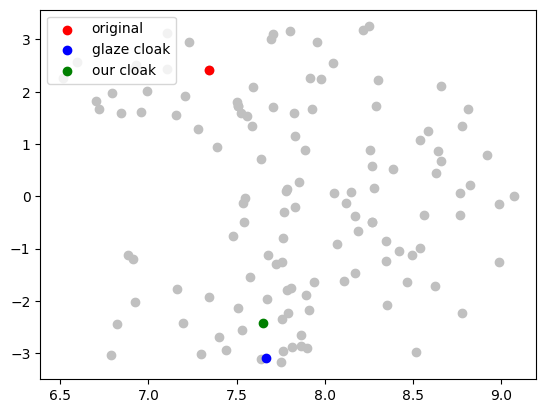

In [113]:
#can use either clip or resnet features, change this parameter for that
use_resnet_features = False
if use_resnet_features:
    feature_vectors = resnet_features
    cloaked = resnet_roses_cloaked
    ours = our_resnet_features
else:
    feature_vectors = clip_features
    cloaked = clip_roses_cloaked
    ours = our_clip_features

#use truncated SVD in place of PCA because we have fewer data points than dimensions in original feature vectors
svd = TruncatedSVD(n_components=2)
data_svd = svd.fit_transform(feature_vectors)
plt.figure()
plt.scatter(data_svd[:, 0], data_svd[:, 1], color = 'silver') #other pictures, here to provide context for moves in feature space
plt.scatter(data_svd[idx,0], data_svd[idx, 1], color = "red", label = 'original') #original Roses image
cloaked_pt = svd.transform([cloaked])
plt.scatter(cloaked_pt[0, 0], cloaked_pt[0, 1], color = 'blue', label = 'glaze cloak') #Roses cloaked by GLAZE
our_pt = svd.transform([ours])
plt.scatter(our_pt[0, 0], our_pt[0, 1], color = "green", label = 'our cloak') #Roses cloaked by our implementation
plt.legend(loc = 'upper left')
plt.show()

In [106]:
#running t-sne next- for more stable results, can use intermediate SVD to hopefully filter out some noise before t-sne
use_int_svd = False
if use_int_svd:
    int_svd = TruncatedSVD(n_components = 20)
    int_svd_data = int_svd.fit_transform(feature_vectors)
    new_features = int_svd_data
    new_cloaked = int_svd.transform([cloaked])
    new_ours = int_svd.transofrm([ours])
else:
    new_features = feature_vectors
    new_cloaked = cloaked
    new_ours = ours

all_data = np.vstack([new_features, new_cloaked, new_ours])
tsne = TSNE(n_components = 2, perplexity = 7)
all_data_tsne = tsne.fit_transform(all_data)
origs = all_data_tsne[:-2]
cloaked_pt = all_data_tsne[-2]
our_pt = all_data_tsne[-1]


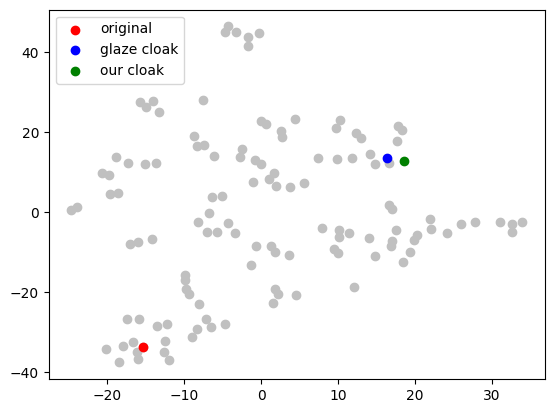

In [112]:
plt.figure()
plt.scatter(origs[:, 0], origs[:, 1], color = "silver")
plt.scatter(origs[idx, 0], origs[idx, 1], color = "red", label = 'original')
plt.scatter(cloaked_pt[0], cloaked_pt[1], color = "blue", label = 'glaze cloak')
plt.scatter(our_pt[0], our_pt[1], color = "green", label = 'our cloak')
plt.legend(loc = 'upper left')
plt.title("Visualization of Feature Data T-SNE Embedding "
plt.show()
